In [68]:
import datetime
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as snsS
import yfinance as yahooFinance
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier


Importando os dados

In [69]:
mercado = pd.read_excel(r'C:\Users\isabella.silveira\Downloads\data_gd\mercado-desafio.xlsx')

In [70]:
transacoes = pd.read_excel(r'C:\Users\isabella.silveira\Downloads\data_gd\transações-desafio-sem-dia-4.xlsx')

In [71]:
GetFacebookInformation = yahooFinance.Ticker("DX-Y.NYB")
dollar = GetFacebookInformation.history(period="2y")
dollar = dollar.reset_index()
dollar.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2023-01-10 00:00:00-05:00,103.290001,103.489998,103.029999,103.239998,0,0.0,0.0
1,2023-01-11 00:00:00-05:00,103.220001,103.480003,103.110001,103.190002,0,0.0,0.0
2,2023-01-12 00:00:00-05:00,103.059998,103.290001,102.080002,102.250000,0,0.0,0.0
3,2023-01-13 00:00:00-05:00,102.209999,102.650002,101.989998,102.199997,0,0.0,0.0
4,2023-01-17 00:00:00-05:00,102.320000,102.559998,101.940002,102.389999,0,0.0,0.0


Série temporal dollar 

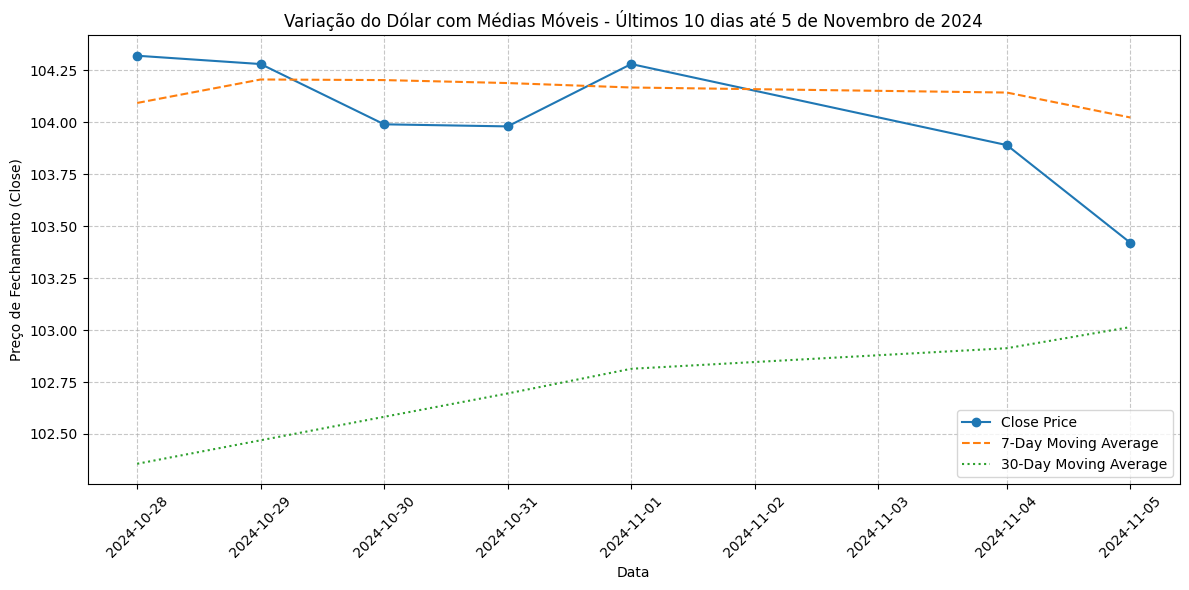

In [72]:
dollar['MA7'] = dollar['Close'].rolling(window=7).mean()
dollar['MA30'] = dollar['Close'].rolling(window=30).mean()

dollar_filtered = dollar[(dollar['Date'] >= '2024-10-26') & (dollar['Date'] <= '2024-11-05')]

plt.figure(figsize=(12, 6))

plt.plot(dollar_filtered['Date'], dollar_filtered['Close'], marker='o', linestyle='-', label='Close Price')

if 'MA7' in dollar_filtered.columns:
    plt.plot(dollar_filtered['Date'], dollar_filtered['MA7'], linestyle='--', label='7-Day Moving Average')

if 'MA30' in dollar_filtered.columns:
    plt.plot(dollar_filtered['Date'], dollar_filtered['MA30'], linestyle=':', label='30-Day Moving Average')

plt.title('Variação do Dólar com Médias Móveis - Últimos 10 dias até 5 de Novembro de 2024')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (Close)')
plt.xticks(rotation=45)
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Mercado

In [73]:
mercado['Product'].value_counts()

Product
Soja     197307
Milho    111162
Name: count, dtype: int64

Revisar pois o produto está de um preço a tarde pela manhã outra precificação

A precificação muda de estado para estado 

Outro tópico é que temos a previsão de mercado dos dia 4 e 5 de novembro e na base de transações não temos 

Transações

In [74]:
print('valores unicos de entrada para cada atributo')
transacoes.nunique().sort_values()

valores unicos de entrada para cada atributo


Product            2
Company            4
origin_state      15
Date             214
origin_city      225
Buyer ID         268
Seller ID       2428
Time            7507
Amount          9512
Price           9513
dtype: int64

In [75]:
print('verificando quantidade de dados ausentes')
print(((transacoes.isnull().sum() / transacoes.shape[0]) * 100).sort_values(ascending=False).round(2))

verificando quantidade de dados ausentes
origin_city     0.02
Amount          0.01
Date            0.00
Time            0.00
Company         0.00
Seller ID       0.00
Buyer ID        0.00
Price           0.00
Product         0.00
origin_state    0.00
dtype: float64


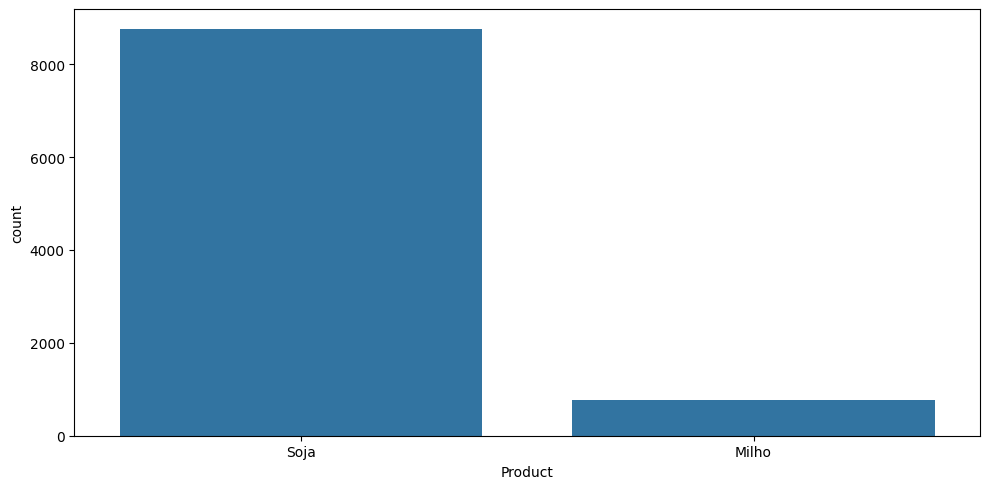

In [76]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x=transacoes.Product)
plt.tight_layout();

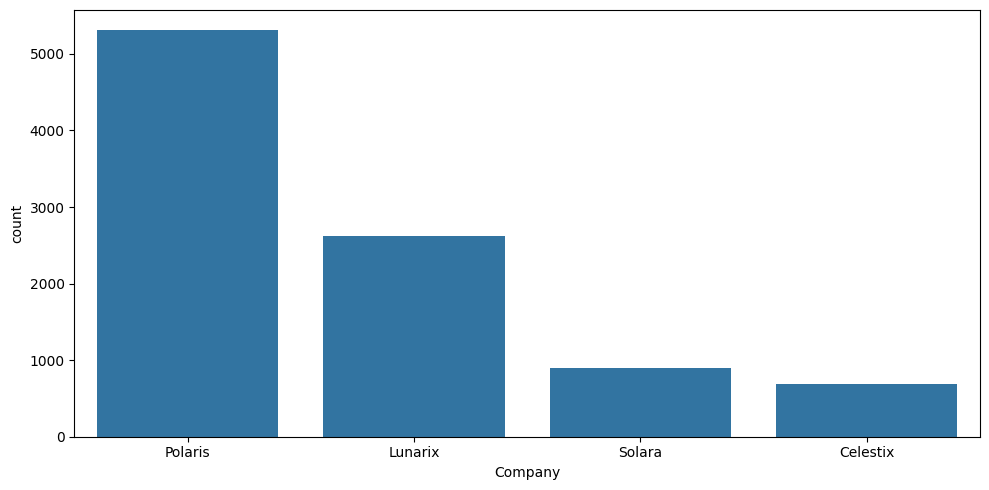

In [77]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x=transacoes.Company)
plt.tight_layout();

### Principais anotações da análise exploratória

-Depende do contexto e do tipo de grão:

-Grãos voltados para exportação (ex.: soja, milho):

-Dólar em queda → Maior dificuldade no mercado externo.
Recomendação: Venda menos no mercado externo e priorize vendas no mercado interno.
Grãos voltados ao mercado interno (ex.: arroz, feijão):

-Dólar em queda → Custos de insumos podem reduzir.
Recomendação: Venda normalmente no mercado interno, ajustando os preços conforme a demanda local.
Se houver sinais de recuperação do dólar:

-Antecipe-se e compre grãos enquanto os preços ainda não refletem a possível alta futura no dólar.

Clusterização 

Definindo cálculo das minhas variáveis quantitativas

In [78]:
transacoes['Date'] = pd.to_datetime(transacoes['Date'])

# Definir a data base para o cálculo de Recency
base_date = pd.to_datetime('2024-11-03')

# Calcular a última transação de cada vendedor (Recency)
recency = transacoes.groupby('Seller ID')['Date'].max().reset_index()
recency['Recency'] = (base_date - recency['Date']).dt.days

# Calcular o número total de transações (Transaction_Count)
transaction_count = transacoes.groupby('Seller ID')['Date'].count().reset_index()
transaction_count.columns = ['Seller ID', 'Transaction_Count']

# Calcular o valor médio das transações (Avg_Amount)
avg_amount = transacoes.groupby('Seller ID')['Amount'].mean().reset_index()
avg_amount.columns = ['Seller ID', 'Avg_Amount']

# Consolidar as variáveis calculadas em um único DataFrame
vendedor_features = recency.merge(transaction_count, on='Seller ID')
vendedor_features = vendedor_features.merge(avg_amount, on='Seller ID')

print(vendedor_features)


      Seller ID       Date  Recency  Transaction_Count    Avg_Amount
0     100000001 2024-02-28      249                  1    569.703694
1     100000002 2024-08-05       90                  5  12204.011317
2     100000003 2024-08-05       90                  4  14230.883529
3     100000004 2024-07-29       97                  6  15371.419879
4     100000005 2024-10-30        4                 10  13845.854058
...         ...        ...      ...                ...           ...
2423  100002424 2024-11-01        2                  1   2555.153915
2424  100002425 2024-10-15       19                  1   4860.857571
2425  100002426 2024-11-04       -1                  1   9584.640097
2426  100002427 2024-10-24       10                  1   1685.888671
2427  100002428 2024-10-24       10                  1  10342.657887

[2428 rows x 5 columns]


2428 diferentes vendedores na base

In [79]:
distinct_seller_count = transacoes['Seller ID'].nunique()

distinct_seller_count


2428

Resumo dos clusters:
            Recency  Transaction_Count    Avg_Amount  Vendedor_Count
Cluster                                                             
0        113.717546           3.915822   4206.566243            1972
3        106.694915           3.742938  22473.701019             354
1_2      119.872549           4.568627  87029.097184             102

Cluster mais promissor: 1_2

Vendedores do cluster mais promissor:
      Seller ID       Date  Recency  Transaction_Count     Avg_Amount Cluster
6     100000007 2024-06-20      136                  1  172625.149741     1_2
7     100000008 2024-10-16       18                  5  104924.626598     1_2
8     100000009 2024-10-31        3                 34   92793.382188     1_2
20    100000021 2024-08-29       66                  2   46765.702283     1_2
56    100000057 2024-09-24       40                  3   49029.242618     1_2
...         ...        ...      ...                ...            ...     ...
2037  100002038 2024

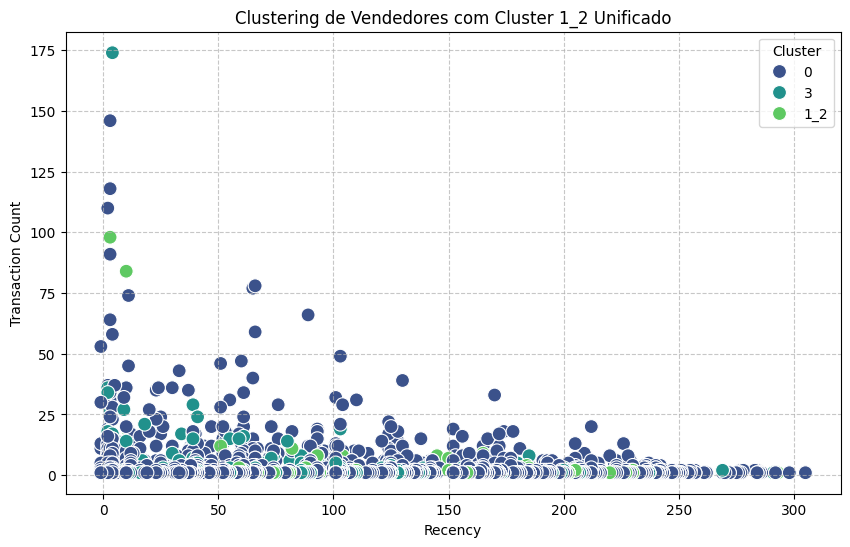

In [80]:
df = vendedor_features

features = df[['Recency', 'Transaction_Count', 'Avg_Amount']]

kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(features)

df['Cluster'] = df['Cluster'].replace({1: '1_2', 2: '1_2'})

cluster_summary = df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Transaction_Count': 'mean',
    'Avg_Amount': 'mean',
    'Seller ID': 'count' 
}).rename(columns={'Seller ID': 'Vendedor_Count'})

cluster_melhor = '1_2'

vendedores_cluster_melhor = df[df['Cluster'] == cluster_melhor]

print("Resumo dos clusters:")
print(cluster_summary)
print("\nCluster mais promissor:", cluster_melhor)
print("\nVendedores do cluster mais promissor:")
print(vendedores_cluster_melhor)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Recency', y='Transaction_Count', hue='Cluster', palette='viridis', s=100)
plt.title('Clustering de Vendedores com Cluster 1_2 Unificado')
plt.xlabel('Recency')
plt.ylabel('Transaction Count')
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.legend(title='Cluster')
plt.show()



 Conferência acertos dia 4

In [81]:
transacoes = pd.DataFrame() 
transacoes['Seller ID'] = df['Seller ID']  
transacoes = transacoes.merge(df[['Seller ID', 'Cluster']], on='Seller ID', how='left')

transacoes.head()

transacoes.to_excel('transacoes_avaliar.xlsx')


PermissionError: [Errno 13] Permission denied: 'transacoes_avaliar.xlsx'

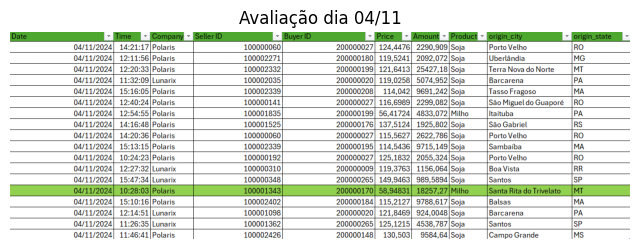

In [ ]:
image_path = 'acertos.png'
img = mpimg.imread(image_path)
plt.figure(figsize=(8, 6))
plt.imshow(img)
plt.axis('off')  # Remover os eixos
plt.title("Avaliação dia 04/11")
plt.show()

### Métricas de acurácia do modelo

Silhouette Score

In [ ]:
features = vendedor_features[['Recency', 'Transaction_Count', 'Avg_Amount']]

kmeans = KMeans(n_clusters=4, random_state=42)

clusters = kmeans.fit_predict(features)

vendedor_features['Cluster'] = clusters

vendedor_features['Cluster'] = vendedor_features['Cluster'].replace({1: '1_2', 2: '1_2'})

cluster_labels = vendedor_features['Cluster'].replace({'1_2': 5}).astype(int)
silhouette_avg = silhouette_score(features, cluster_labels)

print(f"Silhouette Score após unir clusters 1 e 2: {silhouette_avg:.2f}")

print(vendedor_features)



Silhouette Score após unir clusters 1 e 2: 0.71
      Seller ID       Date  Recency  Transaction_Count    Avg_Amount Cluster
0     100000001 2024-02-28      249                  1    569.703694       0
1     100000002 2024-08-05       90                  5  12204.011317       0
2     100000003 2024-08-05       90                  4  14230.883529       3
3     100000004 2024-07-29       97                  6  15371.419879       3
4     100000005 2024-10-30        4                 10  13845.854058       3
...         ...        ...      ...                ...           ...     ...
2423  100002424 2024-11-01        2                  1   2555.153915       0
2424  100002425 2024-10-15       19                  1   4860.857571       0
2425  100002426 2024-11-04       -1                  1   9584.640097       0
2426  100002427 2024-10-24       10                  1   1685.888671       0
2427  100002428 2024-10-24       10                  1  10342.657887       0

[2428 rows x 6 columns]


C:\Users\isabella.silveira\AppData\Local\Temp\ipykernel_21144\377652827.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cluster_labels = vendedor_features['Cluster'].replace({'1_2': 5}).astype(int)


Calinski-Harabasz Index e o Davies-Bouldin Index

In [41]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
import pandas as pd

# Selecionar as features numéricas
features = vendedor_features[['Recency', 'Transaction_Count', 'Avg_Amount']]

# Unificar os clusters 1 e 2 no cluster 1_2
vendedor_features['Cluster'] = vendedor_features['Cluster'].replace({1: '1_2', 2: '1_2'})

# Ajustar as labels numéricas para cálculo (necessário para as métricas)
cluster_labels = vendedor_features['Cluster'].replace({'1_2': 5}).astype(int)

# Calcular o Calinski-Harabasz Index (maior é melhor)
calinski_harabasz = calinski_harabasz_score(features, cluster_labels)
print(f"Calinski-Harabasz Index após unir clusters 1 e 2: {calinski_harabasz:.2f}")

# Calcular o Davies-Bouldin Index (menor é melhor)
davies_bouldin = davies_bouldin_score(features, cluster_labels)
print(f"Davies-Bouldin Index após unir clusters 1 e 2: {davies_bouldin:.2f}")


Calinski-Harabasz Index após unir clusters 1 e 2: 3007.63
Davies-Bouldin Index após unir clusters 1 e 2: 0.60


C:\Users\isabella.silveira\AppData\Local\Temp\ipykernel_21144\64142326.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cluster_labels = vendedor_features['Cluster'].replace({'1_2': 5}).astype(int)


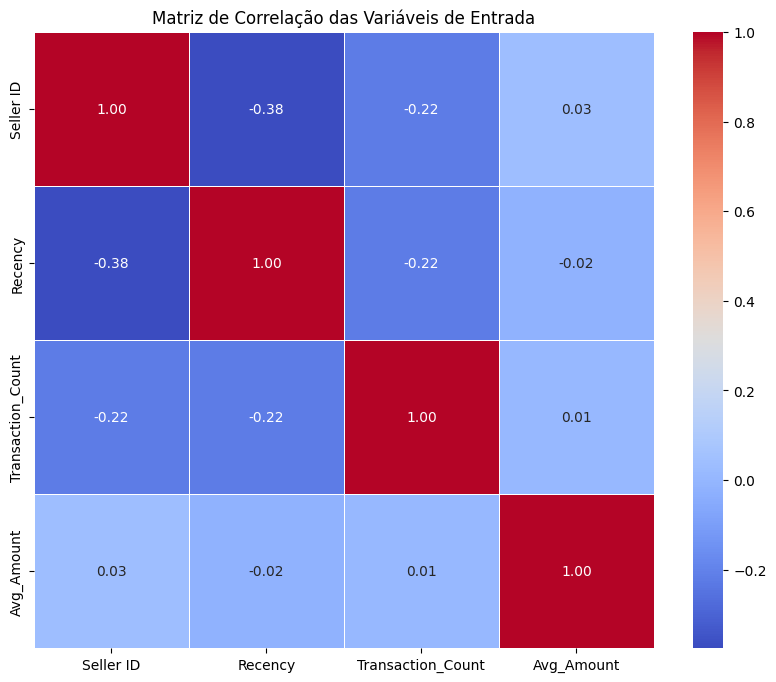

C:\Users\isabella.silveira\AppData\Local\Temp\ipykernel_21144\3975060078.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=column, data=df, palette='viridis')


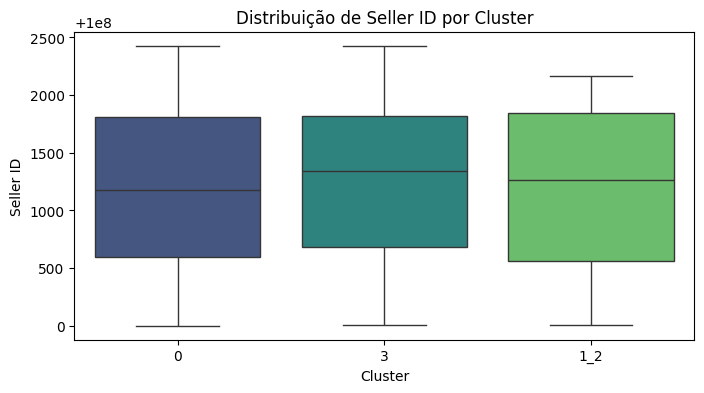

C:\Users\isabella.silveira\AppData\Local\Temp\ipykernel_21144\3975060078.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=column, data=df, palette='viridis')


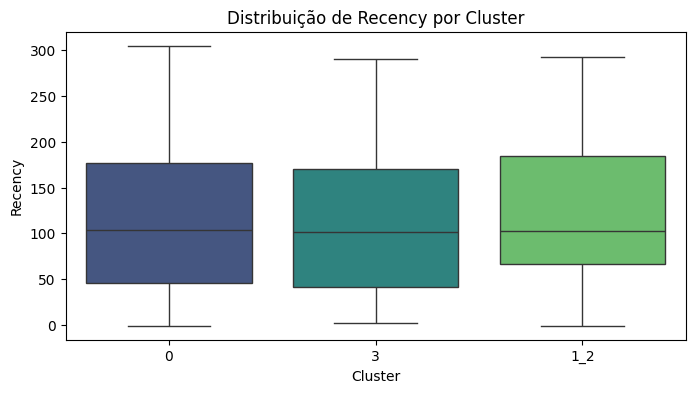

C:\Users\isabella.silveira\AppData\Local\Temp\ipykernel_21144\3975060078.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=column, data=df, palette='viridis')


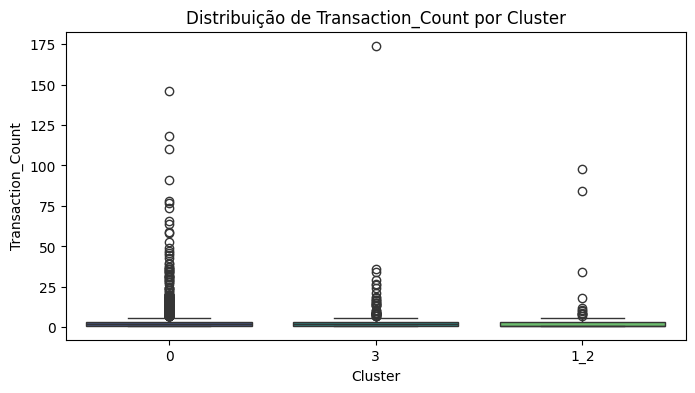

C:\Users\isabella.silveira\AppData\Local\Temp\ipykernel_21144\3975060078.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=column, data=df, palette='viridis')


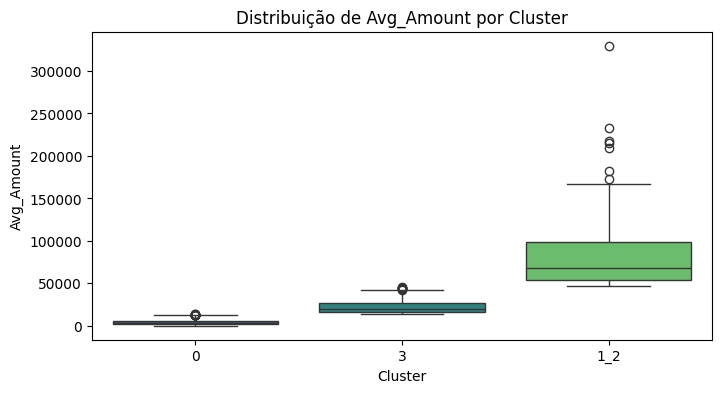

In [52]:
# Calcular a matriz de correlação (removendo a coluna 'Date')
correlation_matrix = df.drop(columns=['Cluster', 'Date']).corr()

# Visualizar a matriz de correlação
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlação das Variáveis de Entrada")
plt.show()

# Verificar distribuições individuais por cluster (removendo 'Date')
for column in df.drop(columns=['Cluster', 'Date']).columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='Cluster', y=column, data=df, palette='viridis')
    plt.title(f'Distribuição de {column} por Cluster')
    plt.show()



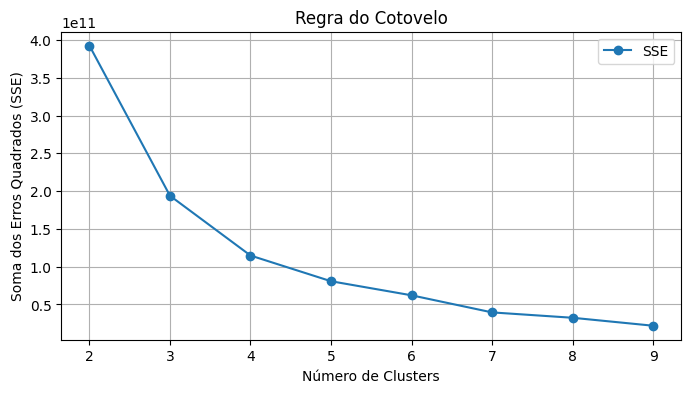

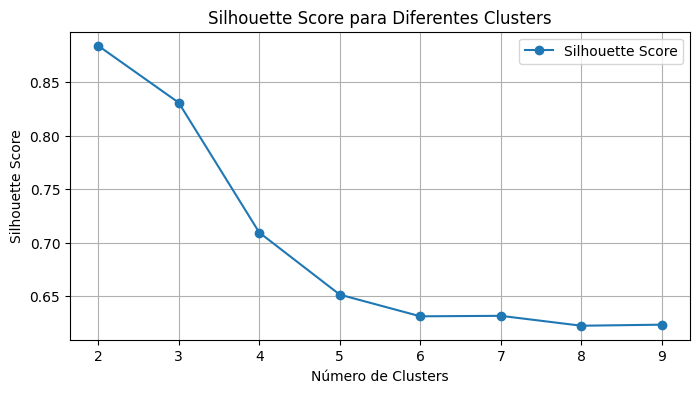

In [ ]:


# Copiar o DataFrame para não alterar o original
df_prepared = df.copy()

# Remover colunas não numéricas ou irrelevantes para clustering
# Substitua 'datetime_col' pelo nome da coluna de data no seu DataFrame
if 'Last_Transaction_Date' in df_prepared.columns:
    df_prepared.drop(columns=['Last_Transaction_Date'], inplace=True)

# Verificar se todas as colunas restantes são numéricas
df_prepared = df_prepared.select_dtypes(include=[int, float])

# Aplicar a Regra do Cotovelo (Elbow Method)
sse = []
silhouette_scores = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_prepared)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_prepared, kmeans.labels_))

# Plotar a Regra do Cotovelo
plt.figure(figsize=(8, 4))
plt.plot(k_values, sse, marker='o', linestyle='-', label='SSE')
plt.title('Regra do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('Soma dos Erros Quadrados (SSE)')
plt.grid()
plt.legend()
plt.show()

# Visualizar Silhouette Score
plt.figure(figsize=(8, 4))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', label='Silhouette Score')
plt.title('Silhouette Score para Diferentes Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.legend()
plt.show()


Verificar balanceamento dos clusters

Distribuição de Vendedores por Cluster:
  Cluster  Vendedor_Count
0       0            1972
1       3             354
2     1_2             102


C:\Users\isabella.silveira\AppData\Local\Temp\ipykernel_21144\3967146718.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Vendedor_Count', data=cluster_balance, palette='viridis')


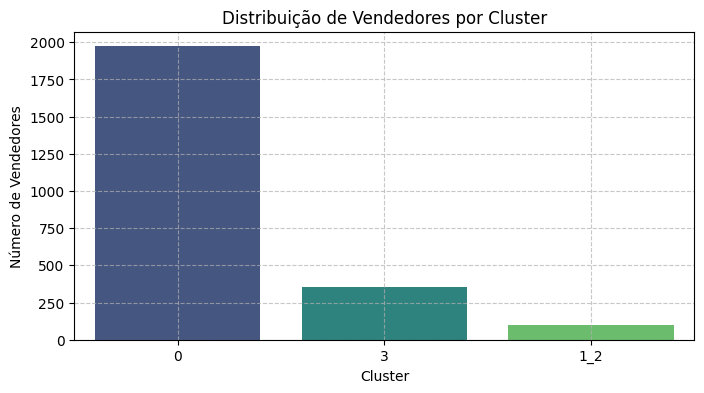

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Contar o número de vendedores por cluster
cluster_balance = vendedor_features['Cluster'].value_counts().reset_index()
cluster_balance.columns = ['Cluster', 'Vendedor_Count']

# Exibir os resultados
print("Distribuição de Vendedores por Cluster:")
print(cluster_balance)

# Visualizar o balanceamento
plt.figure(figsize=(8, 4))
sns.barplot(x='Cluster', y='Vendedor_Count', data=cluster_balance, palette='viridis')
plt.title('Distribuição de Vendedores por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de Vendedores')
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.show()



Impacto no número de clientes

Resumo dos Clusters:
            Recency  Transaction_Count    Avg_Amount  Vendedor_Count
Cluster                                                             
0        113.717546           3.915822   4206.566243            1972
3        106.694915           3.742938  22473.701019             354
1_2      119.872549           4.568627  87029.097184             102


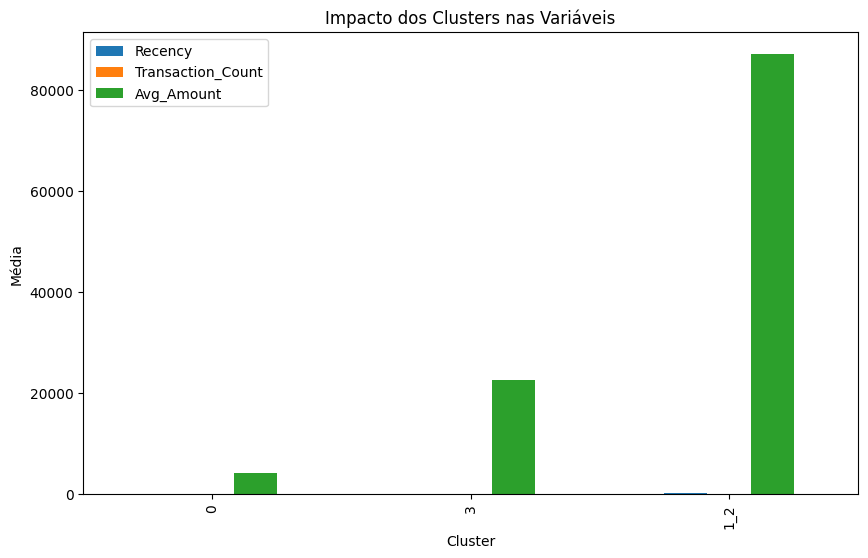

In [ ]:
cluster_summary = df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Transaction_Count': 'mean',
    'Avg_Amount': 'mean',
    'Seller ID': 'count'  
}).rename(columns={'Seller ID': 'Vendedor_Count'})

print("Resumo dos Clusters:")
print(cluster_summary)

cluster_summary.reset_index(inplace=True)
cluster_summary.plot(x='Cluster', y=['Recency', 'Transaction_Count', 'Avg_Amount'], kind='bar', figsize=(10, 6))
plt.title('Impacto dos Clusters nas Variáveis')
plt.xlabel('Cluster')
plt.ylabel('Média')
plt.legend()
plt.show()


Visualizar clusters em diferentes dimensões 

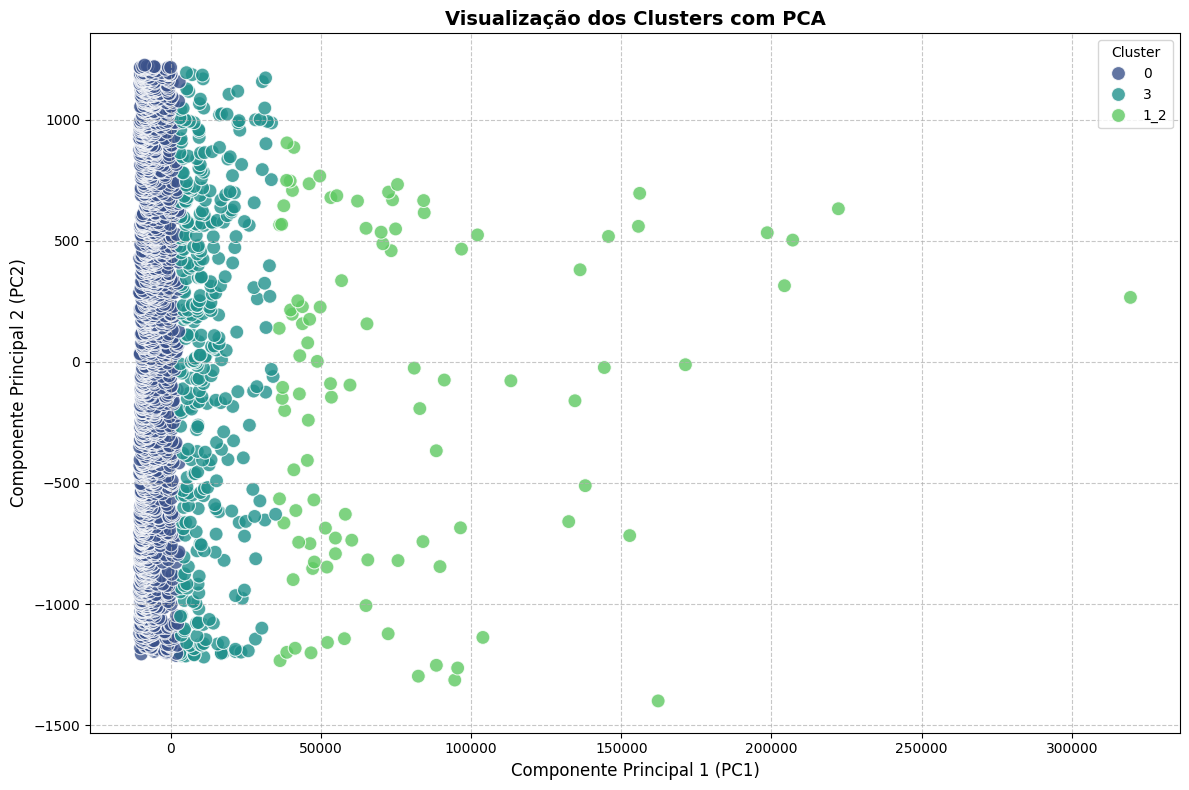

In [47]:

df_numeric = df.select_dtypes(include=[int, float])

if 'Cluster' in df_numeric.columns:
    df_numeric = df_numeric.drop(columns=['Cluster'])

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df_numeric)

reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
reduced_df['Cluster'] = df['Cluster']

plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=reduced_df, palette='viridis', s=100, alpha=0.8)
plt.title('Visualização dos Clusters com PCA', fontsize=14, fontweight='bold')
plt.xlabel('Componente Principal 1 (PC1)', fontsize=12)
plt.ylabel('Componente Principal 2 (PC2)', fontsize=12)
plt.legend(title='Cluster', fontsize=10, loc='upper right')
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



c:\Users\isabella.silveira\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


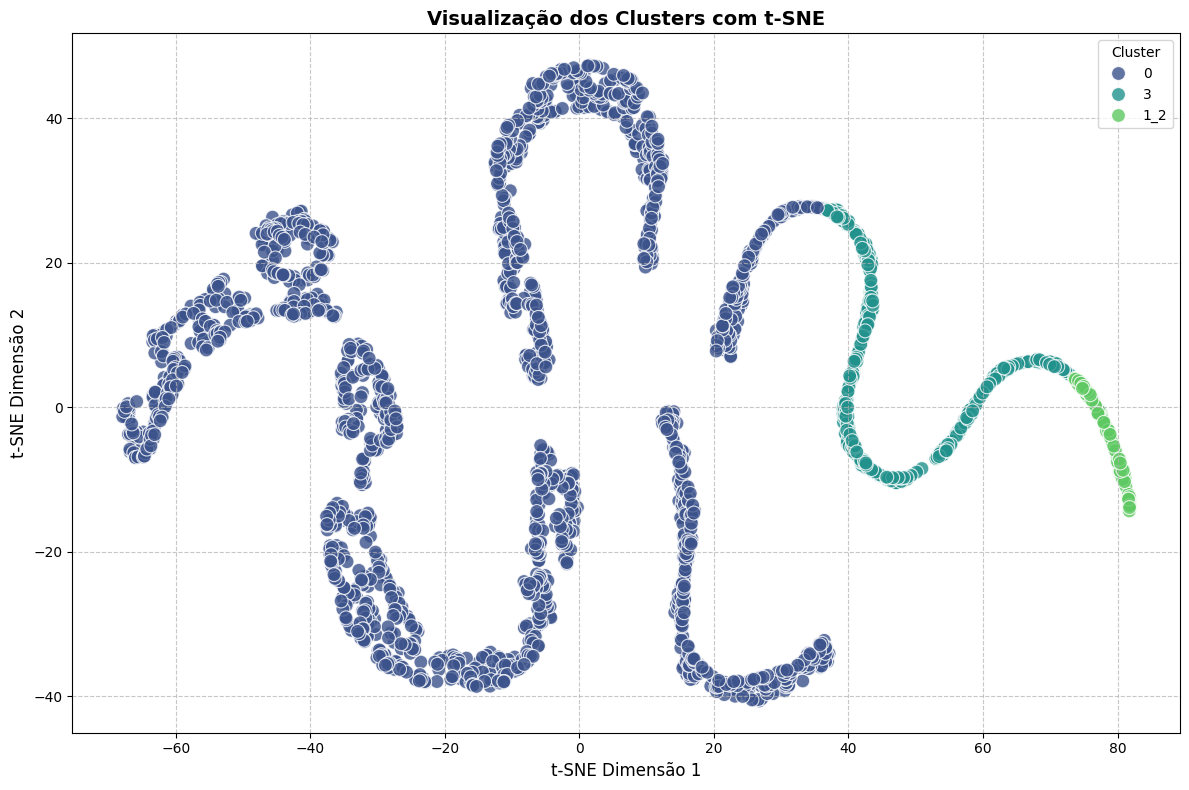

In [48]:


# Reduzir dimensionalidade com t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
reduced_tsne = tsne.fit_transform(df[['Recency', 'Transaction_Count', 'Avg_Amount']])

# Criar DataFrame reduzido
reduced_tsne_df = pd.DataFrame(reduced_tsne, columns=['t-SNE1', 't-SNE2'])
reduced_tsne_df['Cluster'] = df['Cluster']

# Visualizar clusters em 2D
plt.figure(figsize=(12, 8))
sns.scatterplot(x='t-SNE1', y='t-SNE2', hue='Cluster', data=reduced_tsne_df, palette='viridis', s=100, alpha=0.8)
plt.title('Visualização dos Clusters com t-SNE', fontsize=14, fontweight='bold')
plt.xlabel('t-SNE Dimensão 1', fontsize=12)
plt.ylabel('t-SNE Dimensão 2', fontsize=12)
plt.legend(title='Cluster', fontsize=10, loc='upper right')
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

